# Popular Movie Stars
## Objective
1. Get the most popular stars according to his/her rating and valid movie account;
2. Have some insight into the network between popular actors;

## Step 1: Clean the data
Since we only have the data of movie-actor pair and the movie/actor info, the first step is to merge and clean the data here.

 ###  filter the record which is not 'movie'

In [ ]:
import pandas as pd
from pandas import DataFrame, Series


def simplify_data():

    # filter the non-movie kind and merge movie name into the record
    title_movie_only = pd.read_csv('./originalData/movie_basic_info.csv', delimiter='\t', encoding='utf-8',
                               usecols=['tconst', 'titleType', 'primaryTitle'])
    title_movie_only = title_movie_only[title_movie_only['titleType'] == 'movie']
    title_movie_only.drop('titleType', inplace=True, axis='columns')

    data=pd.read_csv('../originalData/principle.csv', delimiter='\t', encoding='utf-8', usecols=['tconst', 'nconst', 'category'])
    data = data[data['category'].isin(['actor', 'actress'])]
    data.drop('category', inplace=True, axis='columns')
    data = pd.merge(title_movie_only, data, on='tconst')

    #  merge the name of actor
    name = pd.read_csv('./originalData/actor_basic_info.csv', delimiter='\t', encoding='utf-8', usecols=['nconst', 'primaryName'])
    data = pd.merge(name, data, on='nconst')
    data.columns=['actorId', 'actorName', 'movieId', 'movieTitle']

    print(data.head())
    data.to_csv("data_simplified.csv", index= False)

### group the data by movie Id and actor Id, hence we got the cast of one movie and the movies one actor is in.

In [ ]:
def group_data():
    data=pd.read_csv('data_simplified.csv', usecols=['movieId', 'actorId'])

    '''
    Group the data by ActorId
    '''
    data_actor=data.groupby('actorId')['movieId'].apply(list)
    data_actor=data_actor.reset_index()
    data_actor.columns=['actorId', 'movies']
    data_actor['count']= data_actor.movies.apply(lambda x: len(x))
    data_actor= data_actor.sort_values('count', ascending=False)
    data_actor.to_csv('data_actor.csv', index=False)

    '''
    Print the actor who has the most screen credit
    '''
    name = pd.read_csv('actor_name.csv', delimiter='\t', encoding='utf-8', usecols=['nconst', 'primaryName'])
    name.columns=['actorId', 'primaryName']
    actor_top_10_num= data_actor[0:20]
    actor_top_10_num= pd.merge(name, actor_top_10_num, on='actorId')
    actor_top_10_num= actor_top_10_num.sort_values('count', ascending=False)
    print(actor_top_10_num[['primaryName', 'actorId']])


    '''
    Group the data by MovieId
    '''
    data_movie=data.groupby('movieId')['actorId'].apply(list)
    data_movie=data_movie.reset_index()
    data_movie.columns=['movieId', 'actors']
    data_movie.to_csv('data_movie.csv', index= False)


    '''
    Create the Connection Graph:
        We think that if two actors appeared in the same movie, then the two actors are connected, here we want to find the 
        connection Graph 
    '''
    def get_connection(movieList):
        actor_in_movies=list(set([a for b in data_movie[data_movie['movieId'].isin(movieList)].actors.tolist() for a in b]))
        return actor_in_movies

    data_actor['connection']=data_actor['movies'].apply(get_connection)
    data_actor.to_csv('connection.csv', columns=['actorId', 'connection'])

### Merge the actor info and movie info into the data we get above

In [ ]:
def merge_movie_data():
    '''

    here we merge data to the form of:  movieId,  actors, rating, numVotes, title
    '''

    title_movie_only = pd.read_csv('./originalData/movie_basic_info.csv', delimiter='\t', encoding='utf-8',
                                   usecols=['tconst', 'titleType', 'primaryTitle'])
    title_movie_only = title_movie_only[title_movie_only['titleType'] == 'movie']
    title_movie_only.drop('titleType', inplace=True, axis='columns')
    title_movie_only.columns=['movieId', 'title']


    rating_info = pd.read_csv('originalData/movie_rating_info.csv', delimiter='\t', encoding='utf-8')
    rating_info.columns = ['movieId', 'rating', 'numVotes']

    data_movie = pd.read_csv('data_movie.csv')
    # from ast import literal_eval
    # data_movie.actors = data_movie.actors.apply(literal_eval())

    data_movie= pd.merge(data_movie, rating_info, on='movieId')
    data_movie= pd.merge(data_movie, title_movie_only, on='movieId')
    data_movie.to_csv('movieInfo.csv', index= False)

def merge_actor_data():
    actor_info=pd.read_csv('originalData/actor_basic_info.csv', delimiter='\t', encoding='utf-8')
    actor_info.columns=['actorId', 'primaryName', 'birthYear', 'deathYear', 'primaryProfession', 'knownForTitles']
    data_actor= pd.read_csv('actor_rating.csv')

    actor_info=pd.merge(data_actor, actor_info, on='actorId')
    actor_info.to_csv('actor_info.csv', columns=['actorId', 'primaryName', 'birthYear', 'deathYear', 'ratings','numVotes','count'], index=False)

def get_actor_rating_votes():
    movie_info=pd.read_csv('movieInfo.csv')
    data_actor= pd.read_csv('data_actor.csv')

    from ast import literal_eval
    data_actor.movies= data_actor.movies.apply(literal_eval)

    def get_rating(movieList):
        df=movie_info[movie_info['movieId'].isin(movieList)]
        ratings=df.rating.tolist()
        numVotes=df.numVotes.tolist()
        return ratings, numVotes
    data_actor['ratings'], data_actor['numVotes'] = zip(*data_actor['movies'].map(get_rating))
    data_actor.to_csv('actor_rating.csv', columns=['actorId', 'ratings', 'numVotes', 'count'], index= False)

## Step 2: Get popular actors and their connection 

Sort the actors according to their rating and number of vote:

In [ ]:
def rating_analysis():
    '''
    analysis the actor who has the most numVotes and rating
    '''
    actor_info= pd.read_csv("actor_info.csv", usecols=['actorId', 'ratings', 'numVotes', 'count', 'primaryName'])
    from ast import literal_eval
    actor_info.numVotes=actor_info.numVotes.apply(literal_eval)
    actor_info.ratings=actor_info.ratings.apply(literal_eval)
    def get_aver_rating(x):
        return  sum(x.ratings)/x['count']
    def get_aver_vote(x):
        return sum(x.numVotes)/x['count']
    actor_info['averRating']=actor_info.apply(get_aver_rating, axis=1)
    actor_info['averVote']=actor_info.apply(get_aver_vote, axis= 1)
    actor_info['validCount']=actor_info.ratings.apply(lambda x: len(x))
    actor_info= actor_info[actor_info['validCount']>=3]
    actor_info= actor_info[actor_info['averVote']>=100]
    actor_info.sort_values('averRating', ascending=False, inplace=True)
    actor_info.to_csv('actor_rating_sorted.csv', index= False)
    actor_info.sort_values('averVote', ascending=False, inplace= True)
    actor_info.to_csv('actor_vote_sorted.csv', index=False)

Here, we have to define the popularity and get the top 100, since we will need information of popularity and some more info(like gender and so on), TMDB database api was introduced here.

In [ ]:
def get_popular_actors():
    '''
    datameta: actorId,primaryName,birthYear,deathYear,ratings,numVotes,count
    we use create a new index: log(averRating*averVote*validCount) to indicate the popularity
    or we can just use the popularity in TMDB
    '''
    actor_info=pd.read_csv("actor_rating_sorted.csv")
    def get_p_index(x):
        return round(x['validCount']*x['averRating']*x['averVote']*x['averRating']/10000000)
    actor_info['p_index']=actor_info.apply(get_p_index, axis=1)
    actor_info.sort_values('p_index', ascending=False, inplace=True)
    # get some range here.
    actor_info= actor_info[0:1000]
    def get_actor_info(actorId):
        import requests
        import time
        time.sleep(0.5)
        url="https://api.themoviedb.org/3/find/"+actorId+"?api_key=af799a17781878f440e337ad70ea9713&language=en-US&external_source=imdb_id"
        response= requests.get(url)
        if response.status_code==200:
            tmdb_id=response.json().get("person_results")[0].get("id")
            url="https://api.themoviedb.org/3/person/"+str(tmdb_id)+"?api_key=af799a17781878f440e337ad70ea9713&language=en-US"
            more_info=requests.get(url)
            if more_info.status_code==200:
                more_info= more_info.json()
                return (more_info.get("gender"),more_info.get("popularity"))
            else:
                print("Connection error")
        else:
            print("Connection Error")
    actor_info['gender'], actor_info['popularity']=zip(*actor_info.actorId.map(get_actor_info))
    actor_info.sort_values("popularity", inplace=True, ascending=False)
    actor_info[0:100].to_csv('popular_actor_top100.csv', index=False)


After the above step, we have almost all the data we need, and also we got some basic info about the score and number of votes. Next step we will merge the data and get the data we use to analyze network;

In [ ]:
def popular_actors_connection():
    popular_actors= pd.read_csv("popular_actor_top100.csv", usecols=['actorId', 'primaryName', 'popularity', 'averRating', 'gender', 'p_index'])
    connection= pd.read_csv("connection.csv", usecols=['actorId', 'connection'])
    actor_connection=pd.merge(connection, popular_actors, on="actorId")
    # print(actor_connection.head())
    popular_id=actor_connection.actorId.tolist()
    from ast import literal_eval
    actor_connection.connection=actor_connection.connection.apply(literal_eval)

    def f(x):
        res=[item for item in x if item in popular_id]
        return res

    def replace_name(x):
        res=[]
        for actorId in x:
            res.append(actor_connection.loc[actor_connection['actorId']==actorId].primaryName.values[0])
        return res
    actor_connection.connection= actor_connection.connection.apply(f)
    actor_connection.connection= actor_connection.connection.apply(replace_name)
    actor_connection.to_csv("popular_actor_connection_100.csv", index=False)


def add_edge_name():
    popular_actors = pd.read_csv("popular_actor_top100.csv",
                                 usecols=['actorId'])
    connection = pd.read_csv("connection.csv", usecols=['actorId', 'connection'])

    actor_connection = pd.merge(connection, popular_actors, on="actorId")
    # print(actor_connection.head())
    popular_id = actor_connection.actorId.tolist()
    from ast import literal_eval
    actor_connection.connection = actor_connection.connection.apply(literal_eval)

    def f(x):
        res = [item for item in x if item in popular_id]
        return res

    actor_connection.connection = actor_connection.connection.apply(f)

    movie_titles=pd.read_csv("originalData/movie_basic_info.csv", usecols=['tconst', 'titleType', 'primaryTitle'], delimiter='\t', encoding='utf-8')

    movie_titles=movie_titles[movie_titles['titleType']=='movie']
    movie_titles.drop('titleType', inplace=True, axis='columns')

    title_dict= Series(movie_titles.primaryTitle.values, index=movie_titles.tconst).to_dict()

    actor_info= pd.read_csv("data_actor.csv", usecols=['actorId','movies'])
    from ast import literal_eval
    actor_info['movies']=actor_info.movies.apply(literal_eval)

    def get_edge(row):
        edge=[]
        index_1= row.actorId
        movie_set_1=set(actor_info[actor_info['actorId']==index_1].movies.iloc[0])

        for index_2 in row.connection:
            if index_1==index_2:
                edge.append("None")
                continue
            movie_set_2= set(actor_info[actor_info['actorId']==index_2].movies.iloc[0])
            common_movies= movie_set_1&movie_set_2
            movie_edge=next(iter(common_movies))
            movie_edge=title_dict.get(movie_edge)
            edge.append(movie_edge)
        return edge
    actor_connection['common_movies']=actor_connection.apply(get_edge, axis=1)
    actor_connection.to_csv("edges.csv", index= False)

def merge_edge():
    edges= pd.read_csv("edges.csv", usecols=["actorId", "common_movies"])
    actor_connection=pd.read_csv("popular_actor_connection_100_raw.csv")
    actor_connection= pd.merge(edges, actor_connection, on="actorId")
    actor_connection.sort_values("p_index", inplace=True, ascending=False)
    actor_connection.to_csv("graph_100.csv", index=False)


if __name__=="__main__":
    popular_actors_connection()
    add_edge_name()
    merge_edge()

## Network visualization

In the previous step, we have all the data needed here. Now it's time for us to analyze the data and perform some visualization.

We will use bokeh/d3.js and networkx to perform visualization here.

In [8]:
import pandas as pd
from pandas import Series
import networkx
from ast import literal_eval
import math


In [9]:
actor_connection=pd.read_csv("graph_100.csv", usecols=['primaryName', 'popularity', 'gender', 'connection','common_movies', 'actorId'])
actor_connection.connection=actor_connection.connection.apply(literal_eval)
actor_connection.common_movies= actor_connection.common_movies.apply(literal_eval)
actor_connection.columns=['actorId', 'common_movies', 'connection', 'actor_name', 'gender', 'score']
actor_connection.head()

,actorId,common_movies,connection,actor_name,gender,score
0,nm0000093,"[The Mexican, Twelve Monkeys, Sinbad: Legend o...","[J.K. Simmons, Bruce Willis, Michelle Pfeiffer...",Brad Pitt,2,13.046934
1,nm0000158,"[The Ladykillers, The Bonfire of the Vanities,...","[J.K. Simmons, Bruce Willis, Leonardo DiCaprio...",Tom Hanks,2,10.635981
2,nm0000148,"[What Lies Beneath, The Devil's Own, Morning G...","[Michelle Pfeiffer, Brad Pitt, Rachel McAdams,...",Harrison Ford,2,14.419894
3,nm0000354,"[Jason Bourne, The Rainmaker, Dogma, All the P...","[Alicia Vikander, Claire Danes, Ben Affleck, P...",Matt Damon,2,11.599721
4,nm0000151,"[The Sum of All Fears, RED, Se7en, Lucy, Wante...","[Ben Affleck, Bruce Willis, Brad Pitt, Scarlet...",Morgan Freeman,2,14.354621


In [10]:
import networkx as nx
actor_scores= actor_connection.score.tolist()
actor_gender= actor_connection.gender.tolist()
actor_names=  actor_connection.actor_name.tolist()
G=nx.Graph()
for actor, score, gender in zip(actor_names, actor_scores, actor_gender):
    G.add_node(actor, score=score, gender=gender)
    

for index, row in actor_connection.iterrows():
    for actor, movie in zip(row.connection, row.common_movies):
        if actor != row.actor_name:
            G.add_edge(row.actor_name, actor, name=movie)
print(nx.info(G))

'''
remove the subgraph here.
'''
for component in list(nx.connected_components(G)):
    if len(component)<3:
        print(component)
        for node in component:
            G.remove_node(node)


Name: 
Type: Graph
Number of nodes: 100
Number of edges: 451
Average degree:   9.0200
{"Dylan O'Brien"}


### Some info about the graph

In [11]:
print("The Graph is biconnected? ", nx.is_biconnected(G))
bicomponents= list(nx.biconnected_components(G))
for component in bicomponents:
    print(component)

The Graph is biconnected?  False
{'Melissa Benoist', 'J.K. Simmons'}
{'Al Pacino', 'Dustin Hoffman', 'Angelina Jolie', 'Emma Stone', 'Milla Jovovich', 'James McAvoy', 'Charlize Theron', 'Gary Oldman', 'Tom Hanks', 'Ewan McGregor', 'Hugh Jackman', 'J.K. Simmons', 'Bruce Willis', 'Pierce Brosnan', 'Monica Bellucci', 'Jared Leto', 'Jason Statham', 'Anna Kendrick', 'Keanu Reeves', 'Jennifer Lawrence', 'Jennifer Jason Leigh', 'Claire Danes', 'Sean Bean', 'Tom Hiddleston', 'Mark Ruffalo', 'Diane Lane', 'Daniel Radcliffe', 'Benedict Cumberbatch', 'George Clooney', 'Johnny Depp', 'Tom Cruise', 'Cate Blanchett', 'Chris Hemsworth', 'Gerard Butler', 'Matt Damon', 'Sean Connery', 'Mel Gibson', 'Jeremy Irons', 'Edward Norton', 'Sylvester Stallone', 'James Franco', 'Daniel Craig', 'Harrison Ford', 'Brad Pitt', 'Scarlett Johansson', 'Arnold Schwarzenegger', 'Jessica Alba', 'Michelle Pfeiffer', 'Vin Diesel', 'Chris Pratt', 'Kristen Stewart', 'Kristen Bell', 'Rose Byrne', 'Jennifer Aniston', 'Sally Haw

In [30]:
print("The average clustering:", nx.average_clustering(G))
print("The density:", nx.density(G))
#The max distance between two actors
print("The  max distance between two actors:", nx.diameter(G))
# The average distance between two actors
print("The average distance between two actors:", nx.average_shortest_path_length(G))

# pagerank
import numpy as np
pagerank= nx.pagerank_numpy(G)
pagerank= pd.DataFrame.from_dict(pagerank, orient='index').reset_index()
pagerank.columns=['actor_name', 'pagerank']
print(pagerank.sort_values('pagerank', ascending=False).head(10))

# hits analysis
hits= nx.hits_scipy(G, max_iter= 1000)[0]
hits=pd.DataFrame.from_dict(hits, orient='index').reset_index()
hits.columns=['actor_name', 'hits']
print(hits.sort_values('hits', ascending= False).head(10))

The average clustering: 0.17581739352543369
The density: 0.09297052154195011
The  max distance between two actors: 4
The average distance between two actors: 2.344877344877345
           actor_name  pagerank
28    Charlize Theron  0.022732
3          Matt Damon  0.021739
12  Samuel L. Jackson  0.021082
8        Bruce Willis  0.019294
34     Cate Blanchett  0.018458
25       Nicolas Cage  0.017900
49  Michelle Pfeiffer  0.017688
68   Jessica Chastain  0.016863
4      Morgan Freeman  0.016631
51       Winona Ryder  0.016085
           actor_name      hits
3          Matt Damon  0.026992
12  Samuel L. Jackson  0.023012
8        Bruce Willis  0.022983
28    Charlize Theron  0.022257
0           Brad Pitt  0.021864
34     Cate Blanchett  0.021090
4      Morgan Freeman  0.020235
30       Robin Wright  0.019372
23    Natalie Portman  0.018573
44     Angelina Jolie  0.018079


In [31]:
name=nx.get_edge_attributes(G, 'name')
print(nx.shortest_path(G, "Jackie Chan", "Brad Pitt"))
source="Jackie Chan"
target="Brad Pitt"
path=nx.shortest_path(G, source, target)
for i in range(len(path)-1):
    try:
        common_movie= name[(path[i], path[i+1])]
    except:
        common_movie= name[(path[i+1], path[i])]
    print(path[i]+" and "+path[i+1]+" in movie:", common_movie)

['Jackie Chan', 'Angelina Jolie', 'Brad Pitt']
Jackie Chan and Angelina Jolie in movie: Kung Fu Panda 2
Angelina Jolie and Brad Pitt in movie: Mr. & Mrs. Smith


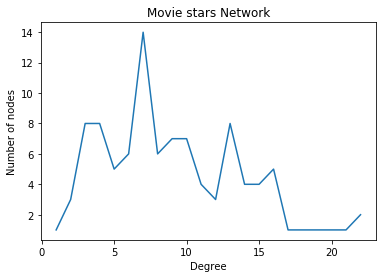

In [14]:
import matplotlib.pyplot as plt

degrees= list(dict(G.degree()).values())
values=sorted(set(degrees))
degree_hist=[degrees.count(x) for x in values]

plt.figure()
plt.plot(values, degree_hist)
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Movie stars Network')
plt.show()
plt.savefig('degree_distribution.png')
plt.close()

In [32]:
import bokeh
from bokeh.io import show, output_file
from bokeh.plotting import figure
from bokeh.plotting import figure
from bokeh.models.graphs import from_networkx

plot= figure(title="Networkx Integration Demonstration", x_range=(-10,10), y_range=(-10,10),
              tools="", toolbar_location=None)
graph= from_networkx(G, nx.spring_layout, scale=10, center=(0,0))
plot.renderers.append(graph)
output_file("network_graph_100.html")
show(plot)

ModuleNotFoundError: No module named 'bokeh.models.graphs'

Save as json to show Interactive Graph

In [27]:
from networkx.readwrite import json_graph
import json
data= json_graph.node_link_data(G)
with open('graph_100.json', 'w') as f:
    json.dump(data, f, indent=2)

## Interactive Graph(Still Debugging)

Check the other folder: network visulization